In [153]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [205]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import and_
from sqlalchemy import or_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [10]:
# We can view all of the classes that automap found
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [ ]:
# reflect the tables

In [14]:
# Save references to each table
Measurement = Base.classes.measurement;
Station     = Base.classes.station; 

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [159]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last data point (max date) from the database
max_date = session.query(func.max(Measurement.date)).first()

In [160]:
# convert string max_date to DATE type last_date
last_date = datetime.strptime(max_date[0], '%Y-%m-%d')
#print(last_date)

In [162]:
# Calculate the date 1 year ago from the last data point in the database
one_year_before = last_date - timedelta(days=365)

In [163]:
last_date_str       = last_date.strftime("%Y-%m-%d")
one_year_before_str = one_year_before.strftime("%Y-%m-%d")

#### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [164]:
# Load the results into a pandas dataframe. 
# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.station, Measurement.prcp, Measurement.date)\
                .filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))

# for r in results:
#     print (r)

In [165]:
df = pd.DataFrame(results[:], columns=['Station', 'Prcp', 'Date'])

### Convert the date column to a Date Type for ease of computation
df['Date'] = pd.to_datetime(df['Date'])
### Set the index to the Date column
df.set_index('Date', inplace=True, )
df.head(10)

,Station,Prcp
Date,,
2016-08-23,USC00519397,0.00
2016-08-24,USC00519397,0.08
2016-08-25,USC00519397,0.08
2016-08-26,USC00519397,0.00
2016-08-27,USC00519397,0.00
2016-08-28,USC00519397,0.01
2016-08-29,USC00519397,0.00
2016-08-30,USC00519397,0.00
2016-08-31,USC00519397,0.13


In [166]:
# Sort the dataframe by date
df = df.sort_index(ascending=False)
df.head()

,Station,Prcp
Date,,
2017-08-23,USC00516128,0.45
2017-08-23,USC00519523,0.08
2017-08-23,USC00514830,0.00
2017-08-23,USC00519397,0.00
2017-08-22,USC00519523,0.00


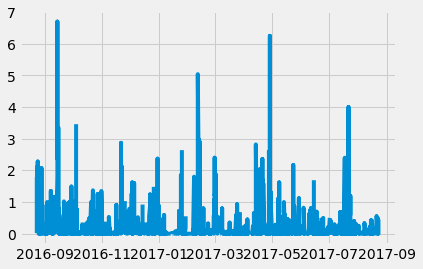

In [167]:
x_values = df.index
y_values = df['Prcp']

ax = plt.gca()

plt.plot(x_values, y_values)
#plot values

plt.show()

In [156]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [193]:
# Design a query to show how many stations are available in this dataset?
#print(Station.__dict__.keys())

num_stations = session.query(func.count(Station.station)).first()
print(f"There are {num_stations[0]} stations available in this dataset ")


There are 9 stations available in this dataset 


In [194]:
number_of_stations = session.query(func.count(distinct(Measurement.station))).first()
print(f"There are {number_of_stations[0]} stations available in this dataset")

There are 9 stations available in this dataset


In [195]:
# results = session.query(Station.id, Station.station, Station.name).\
#     order_by(Station.id.desc()).all()

# for r in results:
#     print(r)

In [209]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

##### COME BACK AND DO STATION NAME IN. HERE 
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(desc(func.count(Measurement.station)))

#for station in most_active_stations:
#    print(station)
    
station_count_df = pd.DataFrame(most_active_stations[:], columns=['Station', 'Station Count'])
station_count_df

,Station,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [222]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = station_count_df.iloc[0]['Station']
print(station_id)

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).first()
print(low_temp[0])
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).first()
print(high_temp[0])
# print(Measurement.__dict__.keys())
# print(Station.__dict__.keys())


USC00519281
54.0
85.0


In [233]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
            filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))


('USC00519397', 2230)


In [246]:
highest_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs))\
                    .group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs)))
# for h in highest_temp_obs:
#     print (h)
station_tobs = highest_temp_obs[0][0]

my_df = df[df['Station']==station_tobs]
my_df


,Station,Prcp
Date,,
2017-08-18,USC00519281,0.06
2017-08-17,USC00519281,0.01
2017-08-16,USC00519281,0.12
2017-08-15,USC00519281,0.32
2017-08-14,USC00519281,0.00
...,...,...
2016-08-27,USC00519281,0.12
2016-08-26,USC00519281,0.01
2016-08-25,USC00519281,0.06


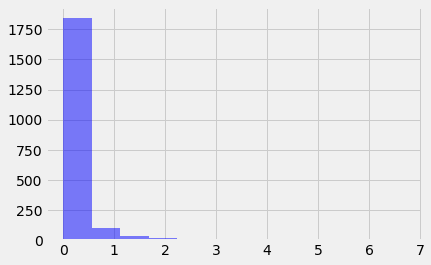

In [255]:
x = df['Prcp']
num_bins = 12
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
# results = session.query(Measurement.station, Measurement.prcp, Measurement.date).\
#     order_by(Measurement.date.desc()).all()